In [ ]:
# We need to import a few packages.
import cv2
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
from numpy import conj, real
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from IPython.display import clear_output
from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount('/content/gdrive', force_remount=True)

%cd /content/gdrive/My Drive
! git clone https://github.com/chuanqi305/KCF.git
%cd KCF/
%ls

Mounted at /content/gdrive
/content/gdrive/My Drive
fatal: destination path 'KCF' already exists and is not an empty directory.
/content/gdrive/My Drive/KCF
car.avi  kcf.py  LICENSE  README.md  run.py


In [ ]:
%cd ..
! git clone https://github.com/ZheyuanXie/KLT-Feature-Tracking.git
%cd ./KLT-Feature-Tracking/
%ls

/content/gdrive/My Drive
fatal: destination path 'KLT-Feature-Tracking' already exists and is not an empty directory.
/content/gdrive/My Drive/KLT-Feature-Tracking
applyGeometricTransformation.py  Fish.mp4           output.avi
demo/                            getFeatures.py     __pycache__/
Easy.mp4                         hard.mp4           README.md
estimateAllTranslation.py        Medium.mp4         results/
estimateFeatureTranslation.py    objectTracking.py  utils.py


In [ ]:
from getFeatures import getFeatures
from estimateAllTranslation import estimateAllTranslation
from applyGeometricTransformation import applyGeometricTransformation

def objectTracking(rawVideo, play_realtime=False, save_to_file=False):
    # initilize
    n_frame = 150
    frames = np.empty((n_frame,),dtype=np.ndarray)
    frames_draw = np.empty((n_frame,),dtype=np.ndarray)
    bboxs = np.empty((n_frame,),dtype=np.ndarray)
    for frame_idx in range(n_frame):
        _, frames[frame_idx] = rawVideo.read()

    # draw rectangle roi for target objects, or use default objects initilization
    n_object = 1
    # easy
    # 945 425 1730 425 1730 875 945 875
    bboxs[0] = np.array([[[945,425],[1730,425],[1730,875],[945,875]]]).astype(float)
    # hard roi: (5, 32, 122, 399)
    # bboxs[0] = np.array([[[5,32],[127,32],[5,431],[127,431]]]).astype(float)
    if save_to_file:
        out = cv2.VideoWriter('output.avi',0,cv2.VideoWriter_fourcc('M','J','P','G'),20.0,(frames[0].shape[1],frames[0].shape[0]))
    
    # Start from the first frame, do optical flow for every two consecutive frames.
    startXs,startYs = getFeatures(cv2.cvtColor(frames[0],cv2.COLOR_RGB2GRAY),bboxs[0],use_shi=False)
    for i in range(1,n_frame):
        print('Processing Frame',i)
        newXs, newYs = estimateAllTranslation(startXs, startYs, frames[i-1], frames[i])
        Xs, Ys ,bboxs[i] = applyGeometricTransformation(startXs, startYs, newXs, newYs, bboxs[i-1])
        
        # update coordinates
        startXs = Xs
        startYs = Ys

        # update feature points as required
        n_features_left = np.sum(Xs!=-1)
        print('# of Features: %d'%n_features_left)
        if n_features_left < 15:
            print('Generate New Features')
            startXs,startYs = getFeatures(cv2.cvtColor(frames[i],cv2.COLOR_RGB2GRAY),bboxs[i])

        # draw bounding box and visualize feature point for each object
        frames_draw[i] = frames[i].copy()
        for j in range(n_object):
            (xmin, ymin, boxw, boxh) = cv2.boundingRect(bboxs[i][j,:,:].astype(int))
            frames_draw[i] = cv2.rectangle(frames_draw[i], (xmin,ymin), (xmin+boxw,ymin+boxh), (255,0,0), 2)
            for k in range(startXs.shape[0]):
                frames_draw[i] = cv2.circle(frames_draw[i], (int(startXs[k,j]),int(startYs[k,j])),3,(0,0,255),thickness=2)
        
        # imshow if to play the result in real time
        if play_realtime:
            cv2_imshow(frames_draw[i])
            cv2.waitKey(10)
            clear_output(wait=True)
        if save_to_file:
            out.write(frames_draw[i])
    
    if save_to_file:
        out.release()

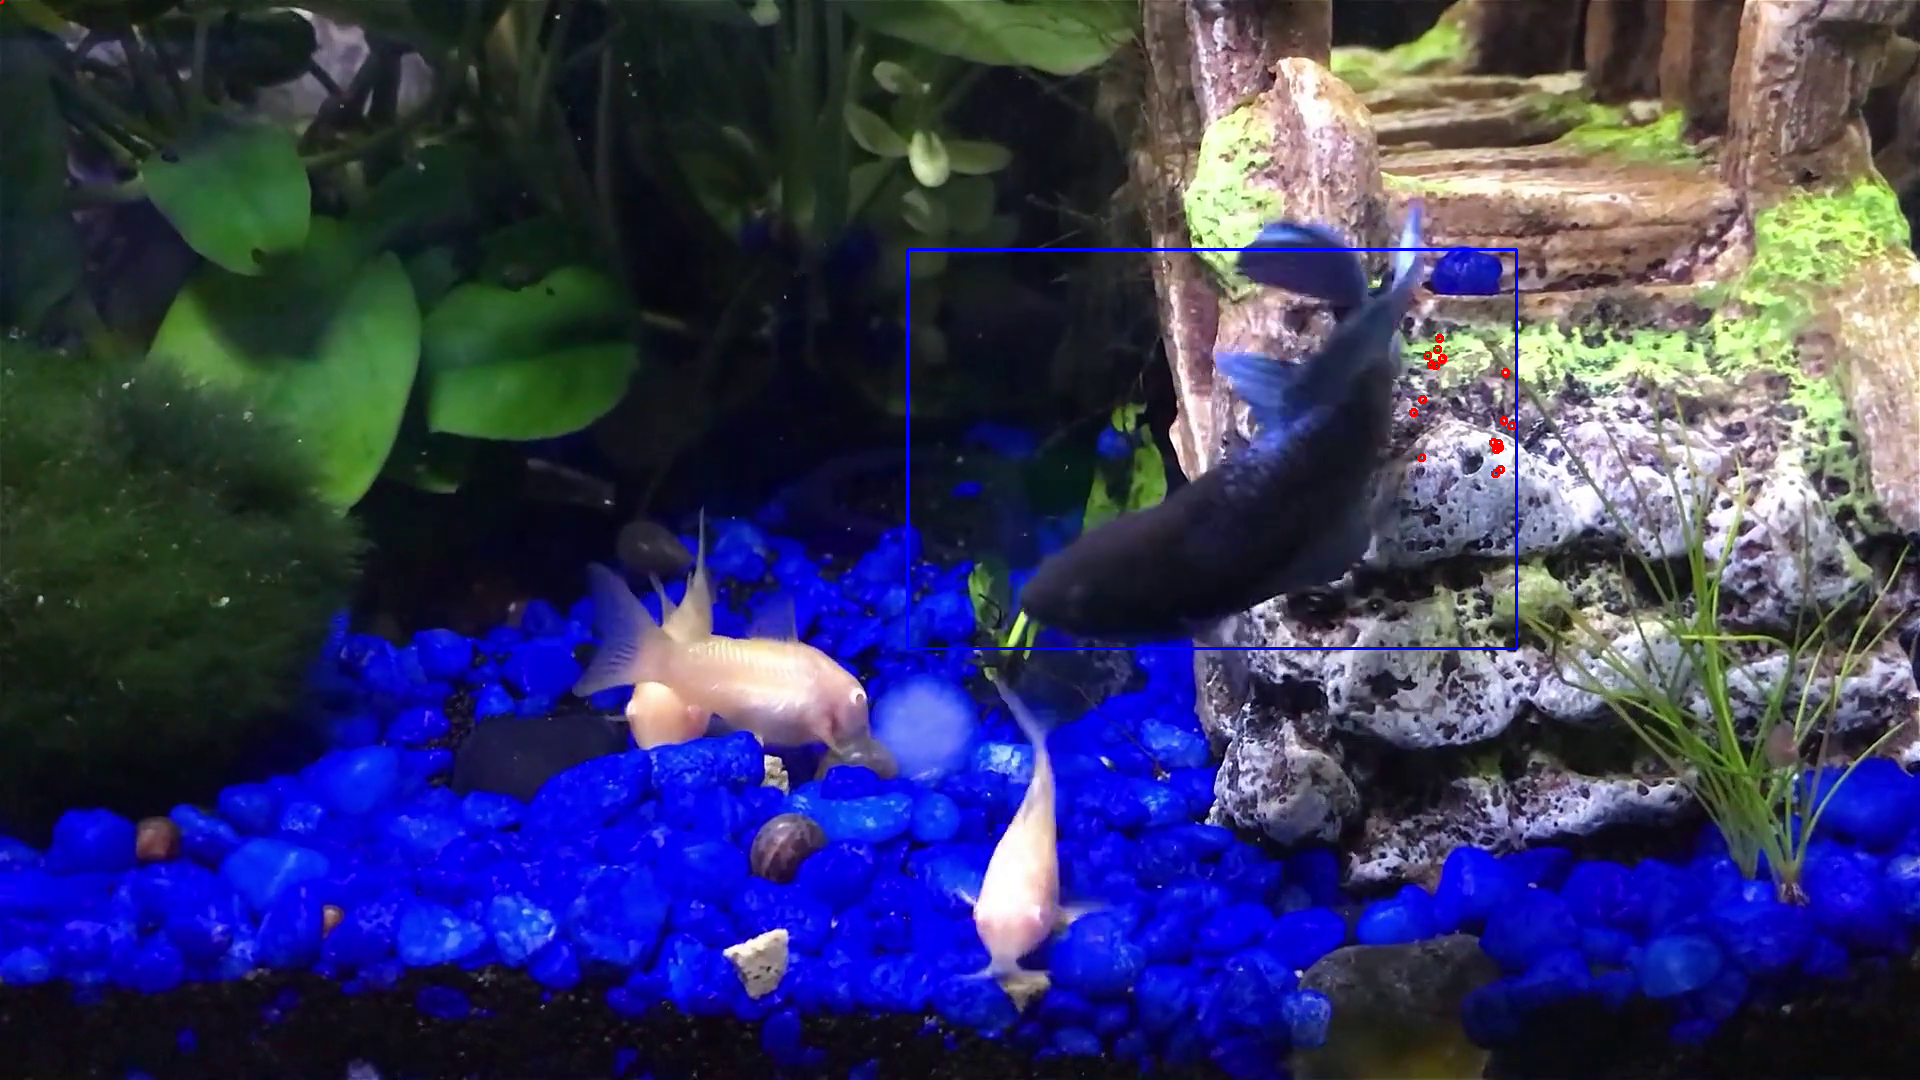

In [ ]:
cap = cv2.VideoCapture("./Fish.mp4")
objectTracking(cap, play_realtime=True,save_to_file=True)
cap.release()